## Using SHAP for interpretability

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import BayesianRidge

import xgboost as xgb
from ngboost import NGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score

import pickle
import shap
shap.initjs()

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
group_one = dataset[dataset["Diagnosis"] == 0]
group_two = dataset[dataset["Diagnosis"] == 3]

combined_group_two = pd.concat([group_one, group_two], ignore_index = True)
combined_group_two["Diagnosis"].unique()

array([0, 3])

In [4]:
combined_group_two

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
1,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
2,14,1,78.6137,0,29.0,0.12,188.33,0.49,183.76,39.63,...,241.64,0.44,226.48,35.11,664.29,3.10,8478.33,3.01,1809.0,3292.0
3,15,0,80.9068,0,29.0,0.10,161.28,0.54,174.53,35.94,...,221.76,0.45,NaN,30.57,NaN,3.12,4287.78,2.90,2188.0,3603.0
4,16,0,65.5205,0,28.0,0.12,166.97,0.58,202.96,38.42,...,228.53,0.50,228.72,28.98,686.36,2.90,-1381.99,2.73,1829.0,3695.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1201,1,75.6411,3,26.0,0.18,173.84,0.59,215.04,33.84,...,281.15,0.37,222.73,27.94,609.75,2.84,-1924.49,1.94,1112.0,2705.0
320,1221,0,71.2712,3,21.0,0.22,174.02,0.58,211.07,30.56,...,224.78,0.47,205.49,27.36,597.20,2.77,1146.39,2.44,1526.0,2913.0
321,1248,1,79.8548,3,23.0,0.19,199.31,0.56,229.63,33.13,...,220.41,0.48,214.97,27.16,639.47,2.79,-919.84,1.99,1215.0,2273.0
322,1253,1,62.7452,3,24.0,0.05,142.05,0.50,147.12,46.21,...,217.38,0.51,220.55,32.54,664.84,3.09,5289.89,3.27,2321.0,3739.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_group_two.drop("Diagnosis", axis=1),  
    combined_group_two["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((226, 23), (98, 23))

In [6]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_bayes.fit(X_train)
X_train_bayes = imputer_bayes.transform(X_train)
X_test_bayes = imputer_bayes.transform(X_test)

In [7]:
X_train_bayes_t = pd.DataFrame(
    X_train_bayes, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_bayes_t = pd.DataFrame(
    X_test_bayes, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [8]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_bayes_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [9]:
X_train_t = pipe.transform(X_train_bayes_t)
X_test_t = pipe.transform(X_test_bayes_t)

X_train_t.shape, X_test_t.shape

((226, 23), (98, 23))

In [10]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	10
Itera

BorutaPy(estimator=RandomForestClassifier(n_estimators=46,
                                          random_state=RandomState(MT19937) at 0x18962520C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x18962520C40, verbose=2)

In [11]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['Ageatscreening', 'MMSE0m', 'ERCsContrastbaseline',
       'ERCsCorelationbaseline', 'ERCsSumVariancebaseline',
       'ERCsEntropybaseline', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

In [12]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((226, 9), (98, 9))

In [13]:
with open("rf_model_group_two.pkl", "rb") as file:
    loaded_model_rf = pickle.load(file)
print(f"{loaded_model_rf} model loaded successfully!\n")

with open("xgboost_model_group_two.pkl", "rb") as file:
    loaded_model_xgb = pickle.load(file)
print(f"{loaded_model_xgb} model loaded successfully!\n")


with open("ngboost_model_group_two.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)
print(f"{loaded_model_ngb} model loaded successfully!")

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       max_features='log2', min_samples_leaf=0.0545655292839688,
                       min_samples_split=0.09778534601105351, n_estimators=168,
                       random_state=42) model loaded successfully!

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7722877910487728, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5543897232349353,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010570327710650527,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=

In [14]:
# Compute SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(loaded_model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_t)

# Compute SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(loaded_model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_t)

# Compute SHAP values for NGBoost
explainer_ngb = shap.Explainer(loaded_model_ngb.predict_proba, X_test_t)
shap_values_ngb = explainer_ngb(X_test_t)

ExactExplainer explainer: 99it [07:05,  4.34s/it]                        


In [15]:
print(shap_values_rf.shape)
print(shap_values_xgb.shape)
print(shap_values_ngb.shape)

(98, 9, 2)
(98, 9)
(98, 9, 2)


## Local interpretability

In [16]:
## SHAP plot for loc trees
explainer_rf = shap.TreeExplainer(loaded_model_rf) 
shap_values_rf = explainer_rf.shap_values(X_test_t)

print(shap_values_rf.shape)
print(explainer_rf.expected_value)

(98, 9, 2)
[0.50160076 0.49839924]


In [17]:
# Force plot for the first instance
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0, :, 1], X_test_t.iloc[0, :], feature_names=X_test_t.columns)

In [18]:
# Force plot for the first instance (class 1)
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[0, :, 0], X_test_t.iloc[0, :], feature_names=X_test_t.columns)

### Plot SHAP beeswarm plots for each class (local per-class perspective)

- For models like Random Forest and NGBoost, which produce class-specific SHAP values (3D arrays), we extract SHAP values per class.
- For XGBoost, which outputs a single set of SHAP values (2D array) for binary classification, the same plot is used for each class iteration (as it doesn’t produce per-class values).
- This approach helps visualize feature importance and distribution of SHAP values for each individual class outcome.

SHAP Beeswarm Plot for Class 0


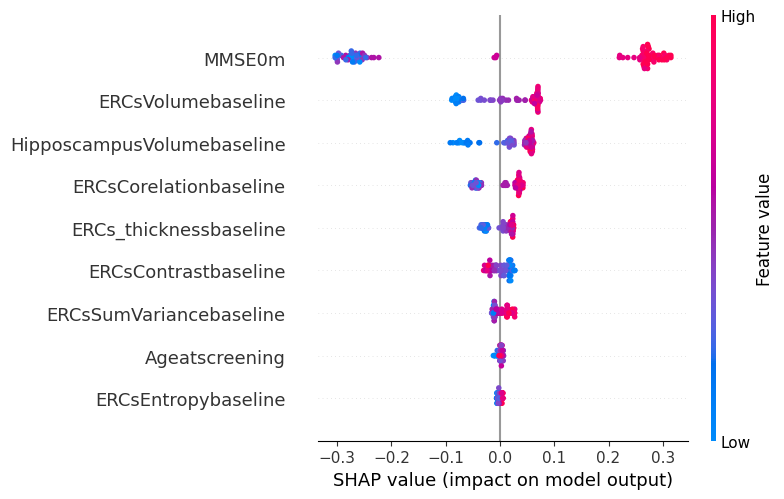

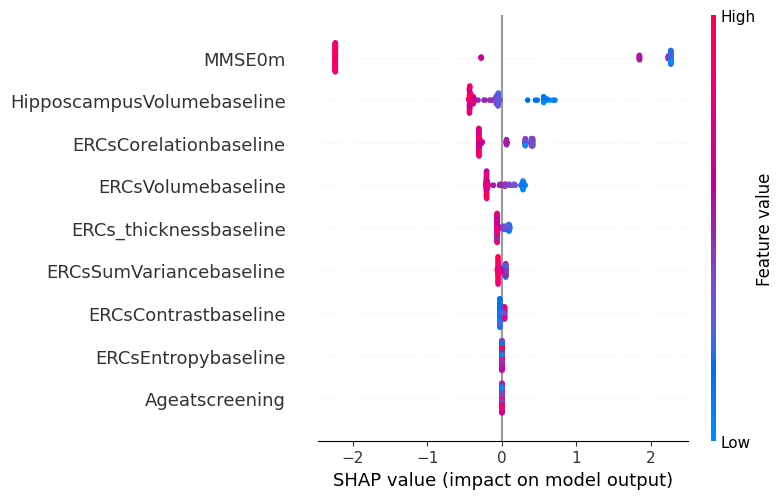

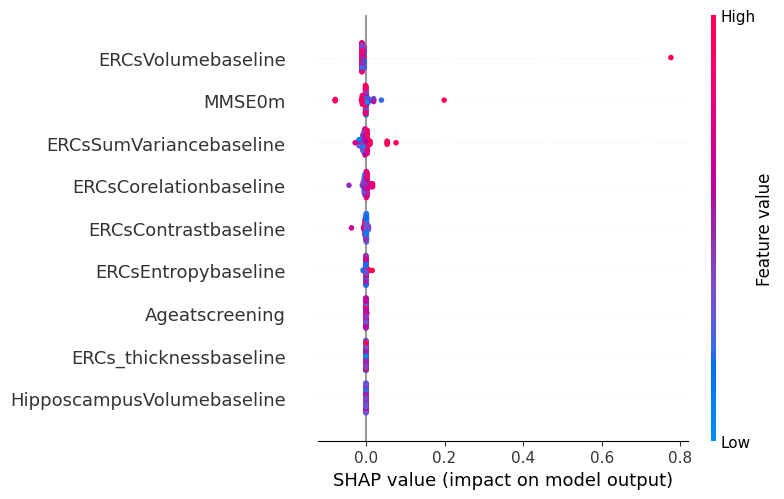

SHAP Beeswarm Plot for Class 1


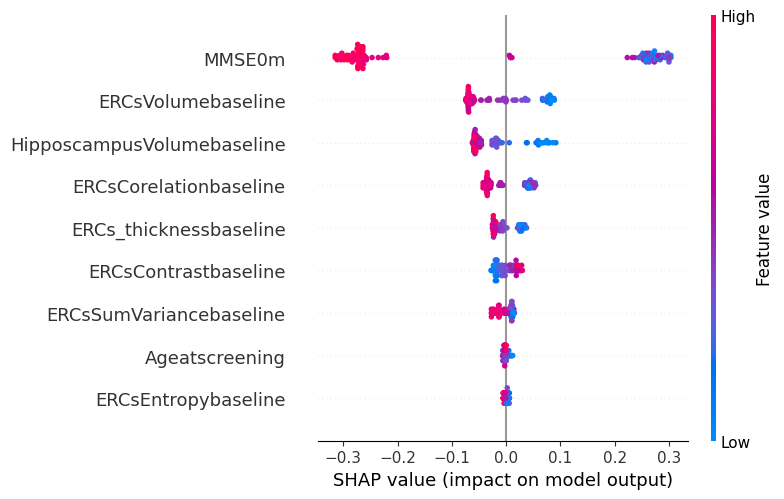

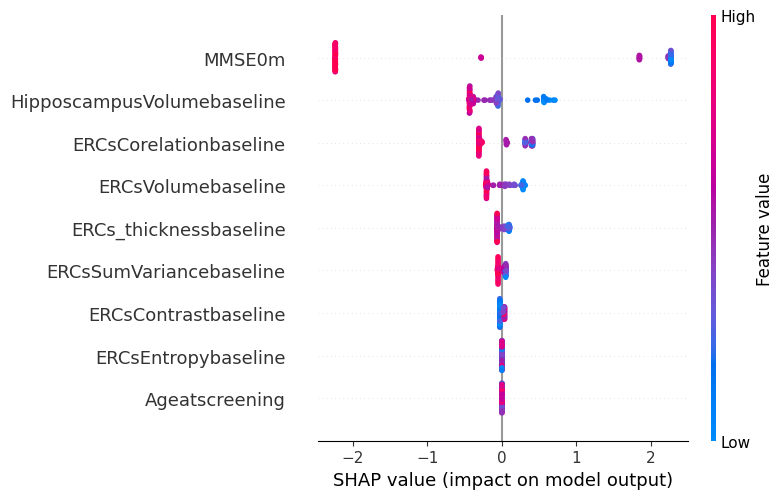

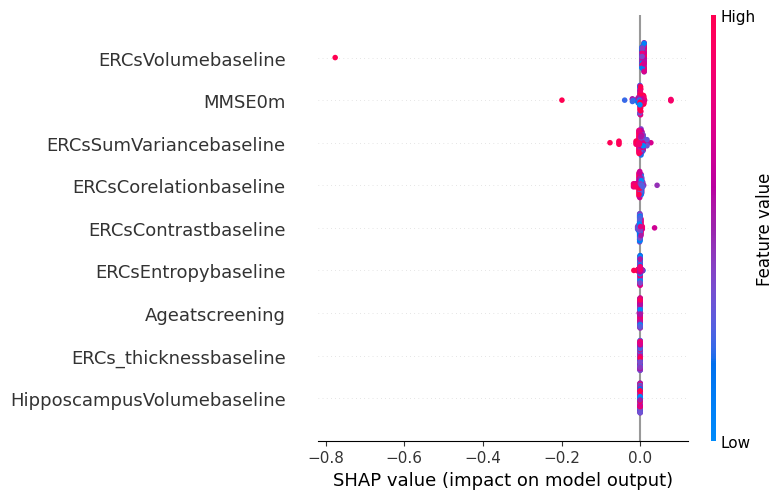

In [19]:
# Plot SHAP beeswarm for each class
for class_idx in range(shap_values_rf.shape[2]):  # Loop over each class (0 and 1)
    print(f"SHAP Beeswarm Plot for Class {class_idx}")

    # For Random Forest
    shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # For XGBoost (shap_values_xgb is 2D, so no need for class_idx)
    shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns)

    # For NGBoost (assuming shap_values_ngb has the same structure as RF, i.e., 3D)
    shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


# Plot aggregated (global) SHAP beeswarm plots across all classes

- XGBoost produces a single 2D array of SHAP values for binary classification, so no aggregation is needed.
- This approach provides a single global view of overall feature importance, irrespective of class, offering a concise summary of how each feature contributes to model predictions across the dataset.


## Global interpretability

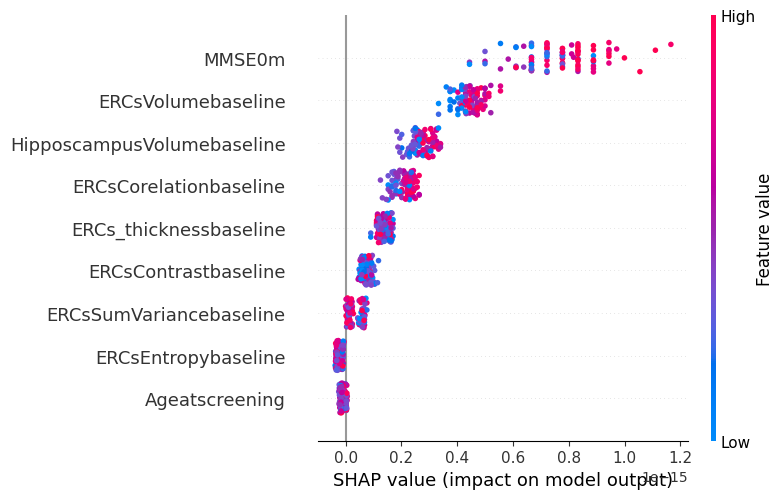

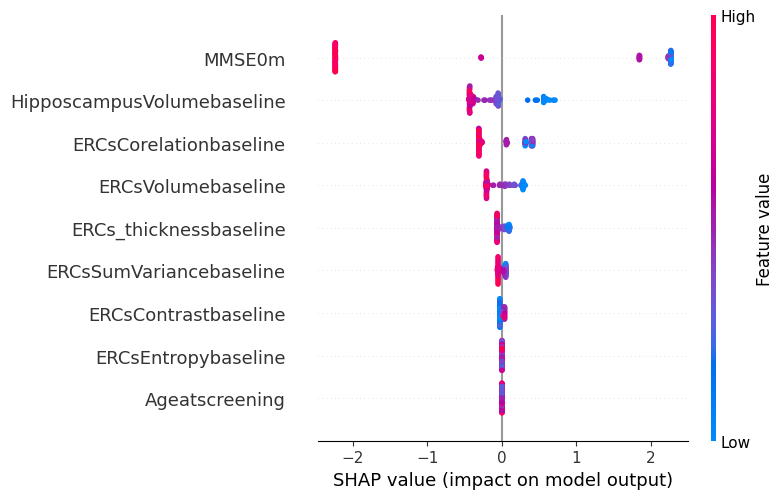

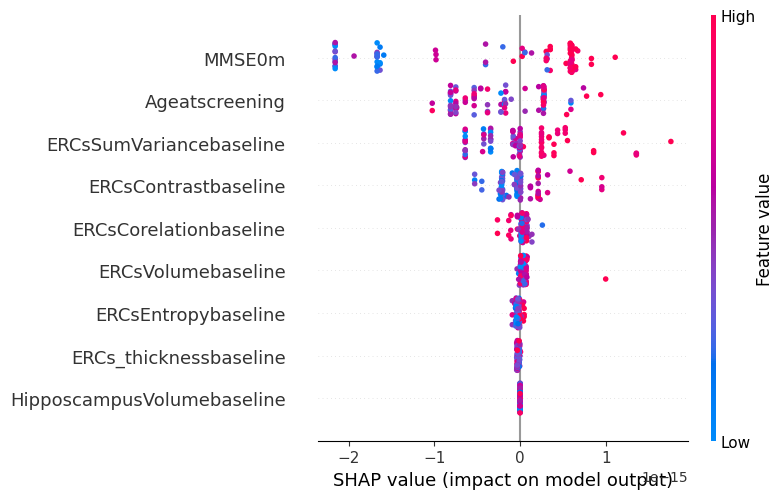

In [20]:
# Sum over classes for models with 3D SHAP arrays
shap_values_rf_sum = shap_values_rf.sum(axis=2)
shap_values_ngb_sum = shap_values_ngb.values.sum(axis=2)

# XGBoost SHAP values are already 2D — no need to sum
shap_values_xgb_sum = shap_values_xgb  # keep as-is

# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)